# Composing multiple deep coadded pictures

This notebooks adapts some of the code of the notebook `DP02_03c` with the goal of creating a large cutout of a sky region starting from inputs similar to the one parsed from the Fermi-GBM GCN.

In [1]:
from lsst.rsp import get_tap_service

def query_and_table(service, query):
    return service.search(query).to_table()
    
service = get_tap_service("tap")

In [2]:
from lsst.daf.butler import Butler

config = 'dp02' 
collection = '2.2i/runs/DP0.2'
butler = Butler(config, collections=collection)

Let's define a cone region. I will take the error radius from the last month GCN ground notice median value. For the target coordinates I will take values from the notebook `DP02_03c`. This sky location corresponds to region at the boundary between two different patches.

In [3]:
err_radius = .3  # max value reached without crash on large VM is 0.19
target_ra = 50.5265
target_dec = -39.7589

Let's define a function returning the RA and dec boundaries of the tightest spherical square containing the cone region.

Now we define a function which takes the box boundaries and returns the spherical coordinates of the corners in SE, SW, NW, NE order. To avoid missing overlapping patches, we enlarge the polygon corners by a margin equal to double the error radius.

In [4]:
import numpy as np

def get_square_region_boundaries(ra: float, dec: float, box_side: float):
    """
    Returns ra_min, ra_max, dec_min, dec_max of a square region centered
    on ra and dec, with box side equal `box_side`.
    All inputs are expected in degrees.
    """
    boundaries_ra = (
        ra - 0.5 * box_side / np.cos(np.radians(dec)), 
        ra + 0.5 * box_side / np.cos(np.radians(dec)), 
    )
    boundaries_dec = (
        dec - 0.5 * box_side,
        dec + 0.5 * box_side,
    )
    return tuple(map(float, [*sorted(boundaries_ra), *sorted(boundaries_dec)]))

def boundaries_to_polygon(ra_min, ra_max, dec_min, dec_max):
    """
    Returns corners of box defined by argument in order SE, SW, NW, NE.
    """
    return (
        (ra_max, dec_min),
        (ra_min, dec_min),
        (ra_min, dec_max),
        (ra_max, dec_max),
    )


boundaries = get_square_region_boundaries(target_ra, target_dec, err_radius)
target_box_min_ra, target_box_max_ra, taget_box_min_dec, target_box_max_dec = boundaries
print(f"RA-dec spherical square box boundaries are: {', '.join(map(lambda f: f'{f:.4f}',boundaries))} deg")
corners = boundaries_to_polygon(*boundaries)
print(f"Corners coordinates are: \n\n{
    '\n'.join(map(
        lambda x: f'{x[0]} (ra = {x[1][0]:.2f}, dec= {x[1][1]:.2f}) deg', 
        [*zip(["SE", "SW", "NW", "NE"], corners)]
    ))}"
)

RA-dec spherical square box boundaries are: 50.3314, 50.7216, -39.9089, -39.6089 deg
Corners coordinates are: 

SE (ra = 50.72, dec= -39.91) deg
SW (ra = 50.33, dec= -39.91) deg
NW (ra = 50.33, dec= -39.61) deg
NE (ra = 50.72, dec= -39.61) deg


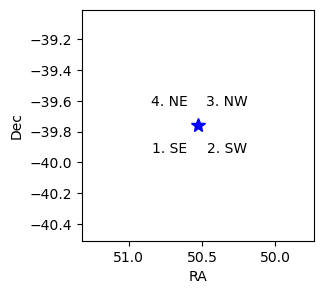

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(3, 3))
plt.plot(target_ra, target_dec, '*', ms=10, color='blue')
clabels = ['1. SE', '2. SW', '3. NW', '4. NE']
for corner, clabel in zip(corners, clabels):
    plt.text(corner[0], corner[1], clabel, ha='center', va='center')
    
plt.gca().invert_xaxis()
plt.xlim([target_box_max_ra + 2 * err_radius, target_box_min_ra - 2 * err_radius])
plt.ylim([taget_box_min_dec - 2 * err_radius, target_box_max_dec + 2 * err_radius])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

Let's write a function which will transform corners into a string we can use for queries, and put together a query to get the patches overlapping with the box. Note that we build the polygon with margin to avoid missing patches.

In [6]:
def polygon_string(corners):
    return f"""{
    ', '.join(map(
        lambda x: f'{x[0]:.4f}, {x[1]:.4f}', 
        corners,
    ))}"""


def sregion_to_vertices(sregion: str, closed=True):
    """Convert the s_region from the ObsCore table into two
    arrays containing the x and y vertices, in order to plot
    boxes using matplotlib.

    from notebook DPO02_02c.
    """
    temp = sregion.split(' ')
    xvertices = []
    yvertices = []
    ix = 2
    iy = 3
    for c in range(4):
        xvertices.append(float(temp[ix]))
        yvertices.append(float(temp[iy]))
        ix += 2
        iy += 2
    if closed:
        xvertices.append(xvertices[0])
        yvertices.append(yvertices[0])
    return xvertices, yvertices

In [7]:
from mocpy import MOC, WCS
import astropy.units as u

PATCH_SIDE_DEG =  13.7 / 60  # deg

def get_square_region_patches_table(service, ra, dec, box_side):
    """
    Returns a table of patch-tracts overlapping with square region defined
    by `ra`, `dec`, `box_side`.
    """
    boundaries = get_square_region_boundaries(ra, dec, box_side + 2 * PATCH_SIDE_DEG)
    return query_and_table(
        service,
        "SELECT lsst_patch,lsst_tract,s_dec,s_ra,s_region "
        "FROM dp02_dc2_catalogs.CoaddPatches "
        "WHERE CONTAINS(POINT('ICRS', s_ra, s_dec), "
        f"POLYGON('ICRS', {polygon_string(boundaries_to_polygon(*boundaries))}))=1"
    )

In [8]:
ptable = get_square_region_patches_table(service, target_ra, target_dec, 2 * err_radius).to_pandas()
ptable.head()

,lsst_patch,lsst_tract,s_dec,s_ra,s_region
0,44,3256,-40.244843,50.885673,POLYGON ICRS 50.733076 -40.358997 51.039264 -4...
1,43,3256,-40.243749,51.176773,POLYGON ICRS 51.024684 -40.358283 51.330849 -4...
2,47,3256,-40.243749,50.012343,POLYGON ICRS 49.858267 -40.356745 50.164432 -4...
3,45,3256,-40.245207,50.594558,POLYGON ICRS 50.441460 -40.358979 50.747656 -4...
4,46,3256,-40.244843,50.303443,POLYGON ICRS 50.149852 -40.358228 50.456041 -4...


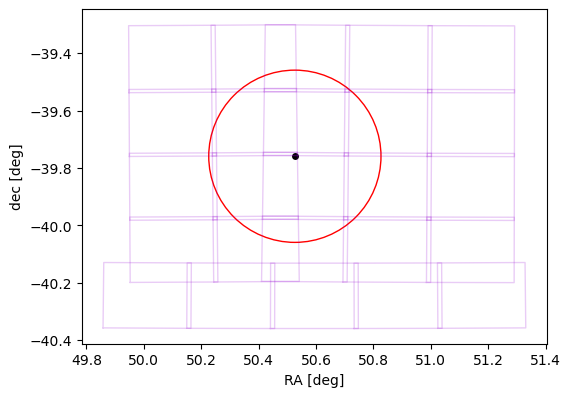

In [9]:
err_circle = plt.Circle((target_ra, target_dec), err_radius, color='r',  fill=False)

fig, ax = plt.subplots(figsize=(6, 6))
ax.axes.set_aspect('equal')
ax.plot(target_ra, target_dec, 'o', ms=5, mew=0, color='black')
ax.add_patch(err_circle)
for i, row in ptable.iterrows():
    xvals, yvals = sregion_to_vertices(row['s_region'])
    ax.plot(xvals, yvals, lw=1, alpha=0.2, color='darkviolet')
ax.set_xlabel("RA [deg]")
ax.set_ylabel("dec [deg]")
plt.show()

In [10]:
def get_circle_region_patches_table(service, ra, dec, radius):
    """
    Returns a table of patch-tracts overlapping with region defined
    by `ra`, `dec`, `err_radius`.

    # TODO: Can the same behaviour be achieved without importing moccpy but by a simple query?
    """
    _t = get_square_region_patches_table(service, ra, dec, 2 * radius).to_pandas()
    moc1 = MOC.from_cone(lon=target_ra * u.deg, lat=target_dec * u.deg, radius=err_radius * u.deg, max_depth=12)
    empty_intersection = [
        i for i, row in _t.iterrows()
        if MOC.from_polygon(
            *map(
                lambda x: np.array(x) * u.deg, 
                sregion_to_vertices(row["s_region"], closed=False)
            )
        ).intersection(moc1).empty()
    ]
    _t = _t.drop(empty_intersection).reset_index()
    return _t 

In [11]:
ptable = get_circle_region_patches_table(service, target_ra, target_dec, err_radius)
ptable.head()

,index,lsst_patch,lsst_tract,s_dec,s_ra,s_region
0,6,15,3441,-39.642252,50.100927,POLYGON ICRS 49.950149 -39.759565 50.253644 -3...
1,7,19,3442,-39.642251,50.851382,POLYGON ICRS 50.698664 -39.758059 51.002160 -3...
2,8,6,3442,-40.082079,50.560934,POLYGON ICRS 50.410443 -40.194730 50.708560 -4...
3,9,7,3441,-39.862682,50.388626,POLYGON ICRS 50.241492 -39.980340 50.538676 -3...
4,10,14,3441,-39.640494,50.385860,POLYGON ICRS 50.239193 -39.758149 50.535425 -3...


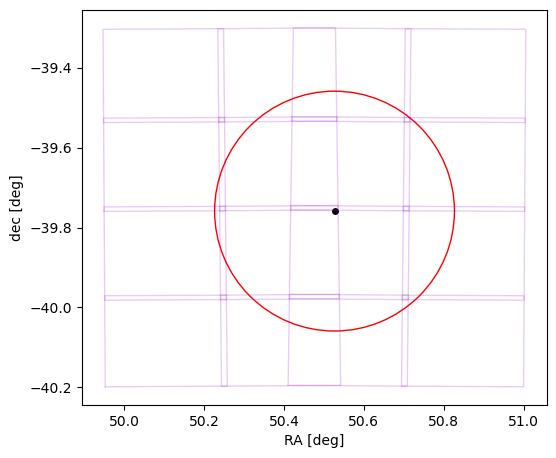

In [12]:
err_circle = plt.Circle((target_ra, target_dec), err_radius, color='r',  fill=False)

fig, ax = plt.subplots(figsize=(6, 6))
ax.axes.set_aspect('equal')
ax.plot(target_ra, target_dec, 'o', ms=5, mew=0, color='black')
ax.add_patch(err_circle)
for i, row in ptable.iterrows():
    xvals, yvals = sregion_to_vertices(row['s_region'])
    ax.plot(xvals, yvals, lw=1, alpha=0.2, color='darkviolet')
ax.set_xlabel("RA [deg]")
ax.set_ylabel("dec [deg]")
plt.show()

We got quite a few tracts. Now we recover the patch-tract with center nearest the target. 

In [13]:
import lsst.geom as geom


def get_tract_and_patch(ra, dec, butler):
    skymap = butler.get('skyMap')
    target = geom.SpherePoint(target_ra * geom.degrees, target_dec * geom.degrees)
    tract = (_tract := skymap.findTract(target)).tract_id
    patch = _tract.findPatch(target).getSequentialIndex()
    return tract, patch

In [14]:
get_tract_and_patch(target_ra, target_dec, butler)

(3442, 13)

Note the tract and patch we get from butler are equal to the one which minimize the angular separation between the center of the tract-patch we queried above, and the target.

In [15]:
from astropy.coordinates import angular_separation

ptable.iloc[
    np.argmin(
        angular_separation(
            ptable["s_ra"], ptable["s_dec"],
            *zip(*[(target_ra, target_dec)] * len(ptable)),
        )
    )]

index                                                        15
lsst_patch                                                   13
lsst_tract                                                 3442
s_dec                                                -39.862681
s_ra                                                  50.563683
s_region      POLYGON ICRS 50.413633 -39.978127 50.710817 -3...
Name: 7, dtype: object

# Anchor image

We call anchor image the deep coadded image from the patch closest to the target. It can be obtained using dedicated functions from `skymap`. I feel it's worth to define our own functions for this.

In [16]:
def get_anchor_image(butler, ra, dec, band):
    tract, patch = get_tract_and_patch(ra, dec, butler)
    return butler.get(
        'deepCoadd_calexp', 
        dataId={
            "tract": tract,
            "patch": patch,
            "band": band,
    })


In [17]:
anchor_img = get_anchor_image(butler, target_ra, target_dec, "r")

We plot the anchor image.

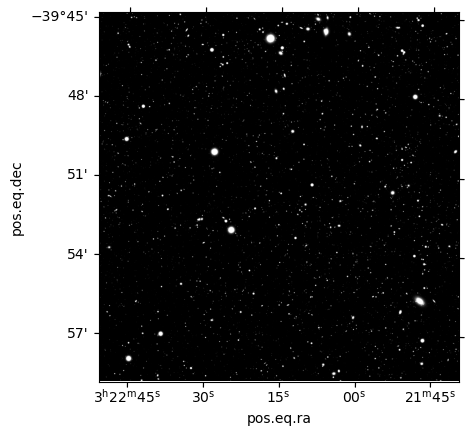

In [18]:
from astropy import units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from photutils.aperture import SkyCircularAperture


img = anchor_img
wcs = WCS(img.getWcs().getFitsMetadata())
coord = SkyCoord(ra=target_ra * u.deg, dec=target_dec * u.deg, frame="icrs")
extent = (img.getBBox().beginX, img.getBBox().endX, img.getBBox().beginY, img.getBBox().endY)

fig = plt.figure()
ax = fig.add_subplot(projection = wcs)
ax.imshow(img.image.array, vmin=.1, vmax=1, extent=extent, origin="lower", cmap="gray")
plt.show()

# Single cutouts

Putting the ingredients needed to compose multiple coadded images together.

In [19]:
from lsst.afw.geom import makeSkyWcs
from lsst.afw.image import Image
import lsst.geom as geom


def get_cutout_dataIds_dict(region_patches_table, bands=["r"]):
    """
    Creates a dictionary with tractIds keys of infos required to fetch individual patches deep coadd.
    """
    all_dataIds_dict = {}
    for i, row in region_patches_table.iterrows():
        tract, patch = map(int, row[["lsst_tract", "lsst_patch"]])
        all_dataIds_dict.setdefault(tract, []).extend([{
            "tract": tract,
            "patch": patch,
            "band": b,
        } for b in bands])
    return all_dataIds_dict

def get_cutout_images_dict(butler, region_patches_table, bands=["r"]):
    """
    Creates a dictionary with tractIds keys of images from each patch.
    """
    all_images_dict = {}
    for i, row in region_patches_table.iterrows():
        tract, patch = map(int, row[["lsst_tract", "lsst_patch"]])
        all_images_dict.setdefault(tract, []).extend([butler.get(
            "deepCoadd_calexp", 
            dataId={
                "tract": tract,
                "patch": patch,
                "band": b,
        }) for b in bands])
    return all_images_dict

def get_cutout_wcs(ra, dec, err_radius, anchor_img):
    """
    Returns a new WCS for a source at center of a region.
    """
    # center coordinates
    crval = geom.SpherePoint(ra, dec, geom.degrees)
    # center pixel
    deepCoadd_pixel_scale = 0.2 # arsec / pixel
    crpix = (2 * err_radius) * 3600 / 2. / deepCoadd_pixel_scale
    crpix = geom.Point2D(crpix, crpix)
    # pixel scale
    x = anchor_img.getWcs().getFitsMetadata()
    cdMatrix = [x['CD1_1'], x['CD1_2']], [x['CD2_1'], x['CD2_2']]
    # projection
    projection = 'TAN'
    return makeSkyWcs(crpix, crval, cdMatrix, projection)

def get_cutout_bbox(ra, dec, err_radius, wcs):
    """
    Returns pixel coordinates of the sky region.
    """
    boundaries = get_square_region_boundaries(ra, dec, 2 * err_radius)
    cSE, _, cNW, _ = boundaries_to_polygon(*boundaries)  # todo: this is likely not necessary
    cSE_deg, cNW_deg = map(lambda x: geom.SpherePoint(*x, geom.degrees), (cSE, cNW))
    corner_SE_pix, corner_NW_pix = map(lambda x: wcs.skyToPixel(x), (cSE_deg, cNW_deg))
    xmin, ymin = map(lambda x: int(np.floor(x)), corner_SE_pix)
    xmax, ymax = map(lambda x: int(np.floor(x)), corner_NW_pix)    
    return Image(
        geom.Box2I(
            minimum=geom.Point2I(x=xmin, y=ymin),
            maximum=geom.Point2I(x=xmax, y=ymax))
        ,
        dtype=np.float32
    ).getBBox()

We can assemble this functions into a new one which will put together the new image, with it's own WCS.

In [20]:
from lsst.ip.diffim import GetTemplateTask


def get_cutout_image(service, butler, ra, dec, err_radius, band="r"):
    """
    Creates a single cutout image for a region with center at (ra, dec) and side length
    equal `2 * err_radius`, in a certain band.

    Notes:
      * some stuff is computed twice in the present implementation. Optimize it later if needed.
    """
    region_patches_table = get_circle_region_patches_table(service, ra, dec, err_radius)
    all_dataIds_dict = get_cutout_dataIds_dict(region_patches_table, [band])
    all_images_dict = get_cutout_images_dict(butler, region_patches_table, [band])

    # this is not necessary and we could optimize to find the anchor from the images_dict but for the moment it's ok
    anchor_img = get_anchor_image(butler, ra, dec, "r") # can be in whatever band, since we only need the image's wcs
    wcs = get_cutout_wcs(ra, dec, err_radius, anchor_img)
    newimage_bbox = get_cutout_bbox(ra, dec, err_radius, wcs)

    getTemplateTask = GetTemplateTask()
    return getTemplateTask.run(
        coaddExposures=all_images_dict, 
        bbox=newimage_bbox,
        wcs=wcs, 
        dataIds=all_dataIds_dict,
        physical_filter=f"{band}_sim_1.4",
    )

In [21]:
new_image = get_cutout_image(service, butler, target_ra, target_dec, err_radius, band="r")

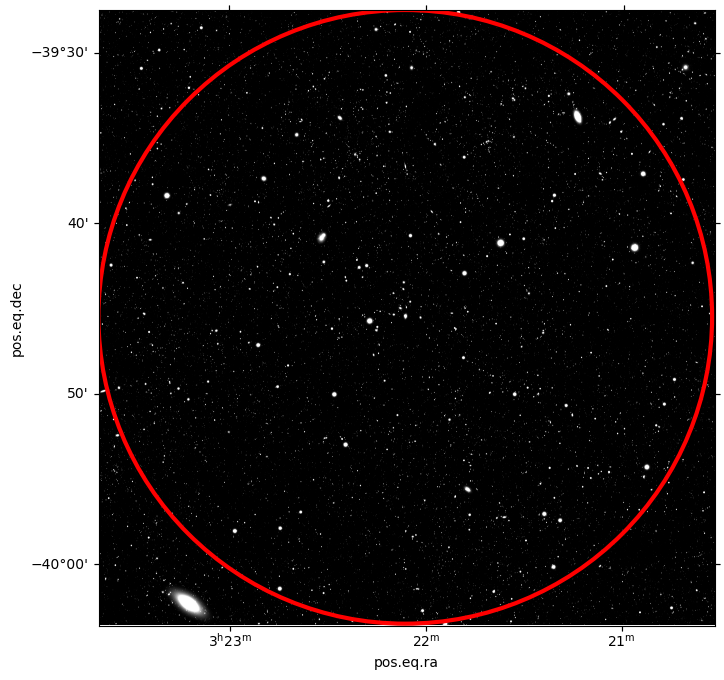

In [22]:
img = new_image.template
wcs = WCS(img.getWcs().getFitsMetadata())
coord = SkyCoord(ra=target_ra * u.deg, dec=target_dec * u.deg, frame="icrs")
extent = (img.getBBox().beginX, img.getBBox().endX, img.getBBox().beginY, img.getBBox().endY)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection = wcs)
ax.imshow(img.image.array, vmin=.1, vmax=1, extent=extent, origin="lower", cmap="gray")
SkyCircularAperture(coord, r=err_radius * u.deg).to_pixel(wcs).plot(color='r', lw=3, ax=ax)
plt.show()

## Multiple cutouts

The time needed to get a single deep coadd cutout of a region with radius 0.1 deg, the quadratic dependence, and the memory limitations all make it unworthy to experiment with regions of the size expected by Fermi GBM localization. 